In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

In [5]:
# Load custom functions

import GAN_171103

# For reloading after making changes
import importlib
importlib.reload(GAN_171103) 
from GAN_171103 import *

Using TensorFlow backend.


In [24]:
# Load engineered dataset from EDA section

data = pd.read_csv('creditcard.csv')

# data columns will be all other columns except class
data_cols = list(data.columns[data.columns != 'Class'])
label_cols = ['Class']

print(data_cols)
print('# of data columns: ',len(data_cols))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
# of data columns:  30


In [25]:
# Put columns in order of importance for xgboost fraud detection (from that section)

# sorted_cols = ['V14', 'V4', 'V12', 'V10', 'V26', 'V17', 'Amount', 'V7', 'V21', 'V28', 'V20', 'V3', 'V18', 'V8', 'V13', 'V22', 'V16', 'V11', 'V19', 'V27', 'V5', 'V6', 'V25', 'V15', 'V24', 'V9', 'V1', 'V2', 'V23', 'Class']
# sorted_cols = ['V14', 'V4', 'V12', 'V10', 'Amount', 'V26', 'V17', 'Time', 'V7', 'V28', 'V21', 'V19', 'V8', 'V3', 'V22', 'V20', 'V25', 'V11', 'V6', 'V16', 'V27', 'V5', 'V18', 'V9', 'V1', 'V2', 'V15', 'V23', 'V24', 'V13', 'Class']
sorted_cols = ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']

data = data[ sorted_cols ].copy()

In [27]:
# Add KMeans generated classes to fraud data - see classification section for more details on this

import sklearn.cluster as cluster

train = data.loc[ data['Class']==1 ].copy()

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels

   count
0    281
1    211


In [28]:
# Function to create toy spiral dataset (looks like swiss roll)

def create_toy_spiral_df( n, seed=0):
    np.random.seed(seed)
    toy = np.array([ [ (i/10+1) * np.sin(i), -(i/10+1) * np.cos(i) ] for i in np.random.uniform(0,3*np.pi,size=n) ])
    toy = pd.DataFrame( toy, columns=[ ['v'+str(i+1) for i in range(2)] ])
    return toy

# toy = create_toy_spiral_df(1000)    
# plt.scatter( toy['v1'], toy['v2'] ) ;

In [29]:
# Function to create toy dataset of multiple groups of normal distributions in n dimensions

def create_toy_df( n, n_dim, n_classes, seed=0):
    toy = pd.DataFrame(columns=[ ['v'+str(i+1) for i in range(n_dim)] + ['Class'] ])
    toy_cols = toy.columns
    np.random.seed(seed)
    for class0 in range(n_classes):
        center0s = np.random.randint(-10,10,size=n_dim)/10
        var0s = np.random.randint(1,3,size=n_dim)/10
        temp = np.array([[class0]]*n)
        for dim0 in range(n_dim):
            temp = np.hstack( [np.random.normal(center0s[dim0],var0s[dim0],n).reshape(-1,1), temp] )
        toy = pd.concat([toy,pd.DataFrame(temp,columns=toy_cols)],axis=0).reset_index(drop=True)
    return toy

# toy = create_toy_df(n=1000,n_dim=2,n_classes=2,seed=0)
# plt.scatter(toy[toy.columns[0]],toy[toy.columns[1]],c=toy['Class'], alpha=0.2) ;

In [31]:
# Load the credit card data

# Original data available from:
# https://www.kaggle.com/dalpozz/creditcardfraud

data = pd.read_csv("creditcard.csv")
print(data.shape)
print(data.columns)
data.head(3)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [32]:
# data columns will be all other columns except class

label_cols = ['Class']
data_cols = list(data.columns[ data.columns != 'Class' ])

print(data_cols)
print('# of data columns: ',len(data_cols))

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
# of data columns:  30


In [33]:
# 284315 normal transactions (class 0)
# 492 fraud transactions (class 1)

data.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

In [34]:
# Total nulls in dataset (sum over rows, then over columns)

data.isnull().sum().sum()

0

In [35]:
# Duplicates? Yes

normal_duplicates = sum( data.loc[ data.Class==0 ].duplicated() )
fraud_duplicates = sum( data.loc[ data.Class==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Fraud duplicates', fraud_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(data) )

Normal duplicates 1062
Fraud duplicates 19
Total duplicates 1081
Fraction duplicated 0.00379555277784605


Last time value: 48.00


C:\Users\Lillian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


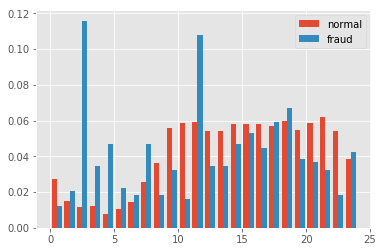

In [36]:
# 'Time' is seconds from first transaction in set
# 48 hours worth of data
# Let's convert time to time of day, in hours

print( 'Last time value: {:.2f}'.format( data['Time'].max() / 3600 ) )

data['Time'] = ( data['Time'].values / 3600 ) % 24

plt.hist( [ data.loc[ data['Class']==0, 'Time'], data.loc[ data['Class']==1, 'Time'] ],
         normed=True, label=['normal','fraud'], bins=np.linspace(0,24,25))
plt.legend()
plt.show()

# Looks like normal transactions have a bias towards 8am to midnight
# Fraud has spikes at 2-3am and noon

In [37]:
# several columns heavily skewed, 'Amount' the highest (besides Class)

data.skew()

Time      -0.499981
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
V5        -2.425901
V6         1.826581
V7         2.553907
V8        -8.521944
V9         0.554680
V10        1.187141
V11        0.356506
V12       -2.278401
V13        0.065233
V14       -1.995176
V15       -0.308423
V16       -1.100966
V17       -3.844914
V18       -0.259880
V19        0.109192
V20       -2.037155
V21        3.592991
V22       -0.213258
V23       -5.875140
V24       -0.552499
V25       -0.415793
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
Class     23.997579
dtype: float64

In [38]:
# Minimum 'Amount' is 0
# 0's account for 0.6% of the data set

print( data['Amount'].min() )
print( np.sum( data['Amount']==0 ) )
# print( np.sum( data['Amount']<0.01 ) )
print( np.sum( data['Amount']==0 ) / len(data) )

0.0
1825
0.006407848121710491


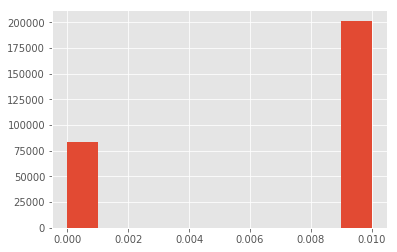

In [39]:
# Looks like all 'Amount' values are rounded to the hundredths (0.01) place
data['Amount'].mod(0.01).hist() ;

In [40]:
# Some values are much more frequent than others
# 0.00 comes in 12th in the list

print( data.Amount.value_counts().head(15) )

1.00     13688
1.98      6044
0.89      4872
9.99      4747
15.00     3280
0.76      2998
10.00     2950
1.29      2892
1.79      2623
0.99      2304
20.00     2002
0.00      1825
8.99      1811
11.50     1741
4.49      1579
Name: Amount, dtype: int64


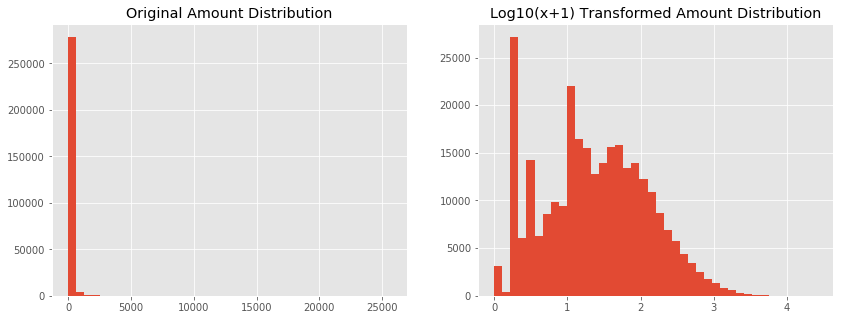

In [41]:
# Log transform amount values to give more normal distribution

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(data['Amount'], bins=40)
plt.title('Original Amount Distribution')

plt.subplot(1,2,2)
d0 = np.log10( data['Amount'].values + 1 )
# d0 = np.log1p( data['Amount'].values ) / np.log(10)
plt.hist( d0, bins=40 )
plt.title('Log10(x+1) Transformed Amount Distribution')
plt.show()

In [42]:
# Use log transformed data

data['Amount'] = d0

In [43]:
# Center and scale all data, only using the middle 99.8%, so outliers don't pull too much.
# First generate the percentile data for each feature

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
min,0.025833,-16.044343,-15.126221,-9.870326,-4.163262,-9.408512,-5.290163,-9.365179,-13.102174,-3.305247,...,-6.621889,-5.490204,-3.119845,-5.452756,-2.001248,-2.403083,-1.276676,-3.823857,-2.629030,0.000000
max,23.965278,2.344685,7.852129,3.387393,6.235906,8.074611,6.164944,7.972745,6.135087,5.960836,...,5.809376,7.879007,2.260348,4.759942,1.246819,1.873743,2.251097,2.607462,2.095818,3.477266
mean,14.543063,0.020195,0.012756,0.011923,-0.003827,0.002532,-0.000677,0.001153,0.011022,-0.002363,...,0.002214,-0.002930,0.001083,0.002081,0.000089,0.000504,-0.001117,0.001314,-0.000914,1.375513
stdev,5.827070,1.814661,1.429787,1.419404,1.383725,1.208541,1.263637,1.018486,0.956445,1.064801,...,0.595668,0.550113,0.704365,0.433626,0.596816,0.505554,0.474011,0.330955,0.223416,0.710045


In [44]:
# Center and scale the data using the percentile data we just generated

data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]

In [45]:
# # Or we can center and scale using all of the data

# from sklearn.preprocessing import StandardScaler

# data[data_cols] = StandardScaler().fit_transform(data[data_cols])

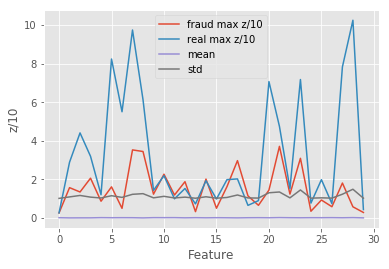

In [46]:
# There are outliers, 50-100 stdevs away from mean in several columns

plot_cols = data_cols
# plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
# plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
plt.plot( data.loc[ data.Class==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='fraud max z/10' )
plt.plot( data.loc[ data.Class==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='real max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend() ; 

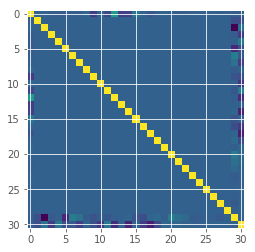

In [47]:
# Check Correlations
# Note no correlations among PCA transformed columns, as expected
corr0 = data.corr()
plt.imshow(corr0) ;

In [48]:
# Looking at correlation values

# np.round(corr0[['Time','Amount','Class']],2)
# plt.imshow( np.round(corr0[['Time','Amount','Class']],2) ) ;
# corr0[data_cols]
# np.round(corr0[data_cols],1)
# np.round(corr0[data_cols],1)

C:\Users\Lillian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\Lillian\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


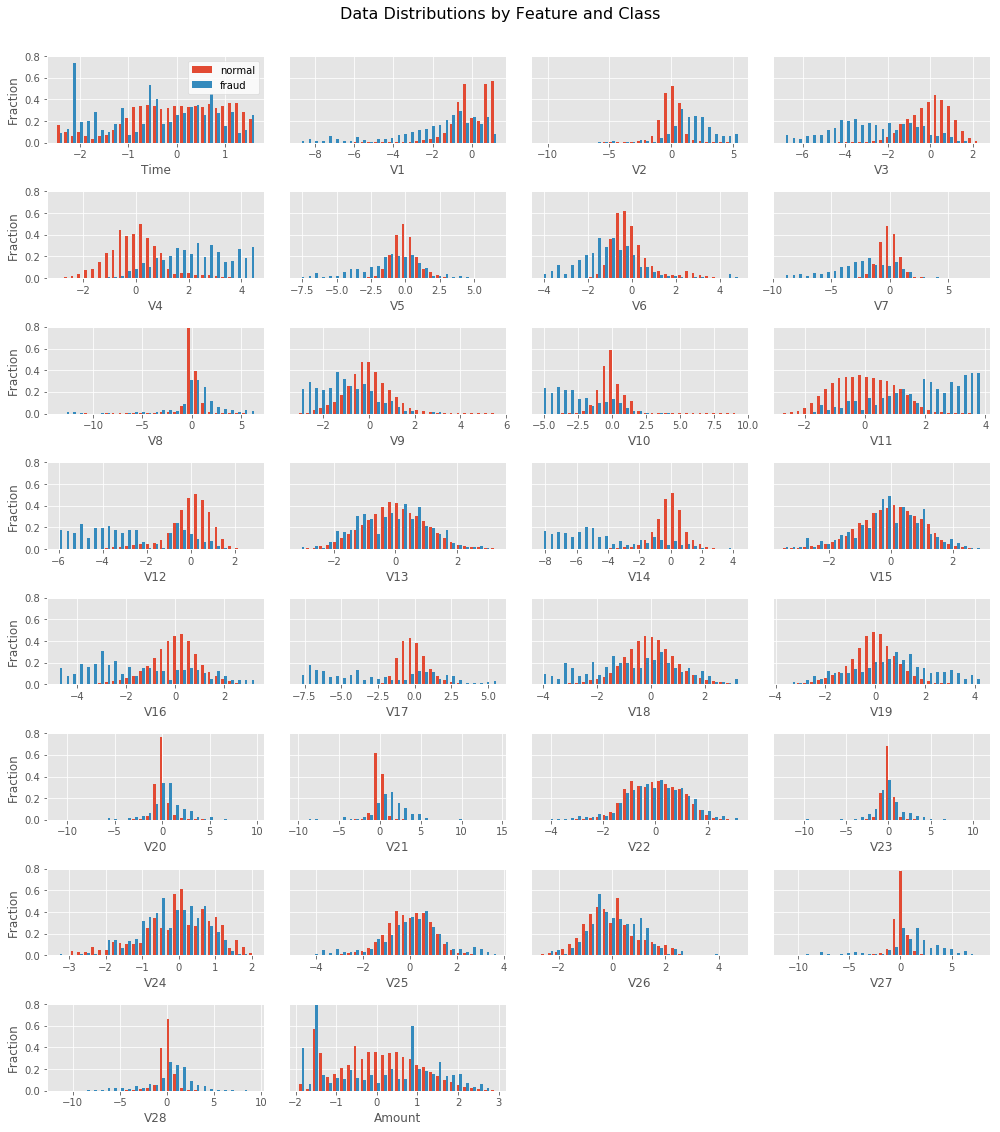

In [49]:
# Plot the data by each feature

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.Class == 0, col ], data.loc[ data.Class == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')
plt.show()

In [54]:
# # Save as csv for human readability - much slower save

data.to_csv('creditcard_engineered.csv')

In [55]:
# define the columns we want to test on, in case we want to use less than the full set

test_cols = data.columns

# test_cols = data.columns[ data.columns != 'Amount' ]

print(len(test_cols))
print(test_cols)

31
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [56]:
# Define some custom metric functions for use with the xgboost algorithm
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

In [57]:
# Set up the test and train sets

np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

classes 0, 1:  284315 492
train, test:  199364 85443


In [58]:
# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['Class'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

[09:22:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[09:22:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=6
[09:22:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[09:22:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[09:22:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[09:22:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[09:22:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

,Pred 0,Pred 1
True 0,85288,7
True 1,35,113


Accuracy : 0.9995084442259752


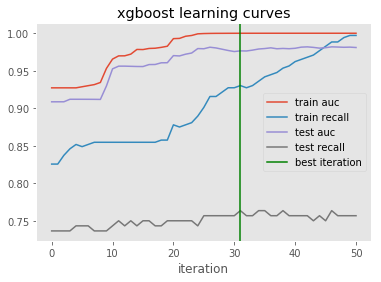

In [59]:
# Let's look at how the metrics changed on the train and test sets as more trees were added

for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

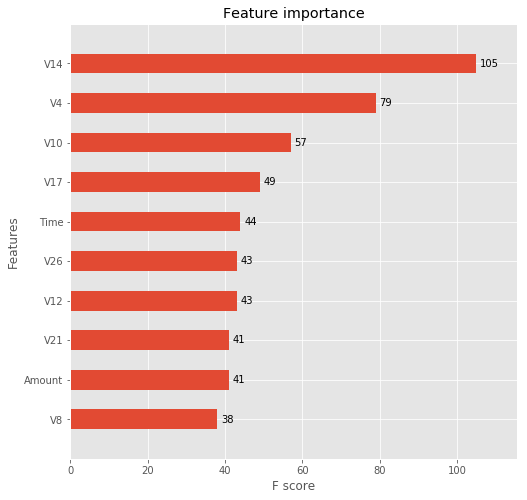

In [60]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=10, height=0.5, ax=ax);

In [61]:
# Generate list of features sorted by importance in detecting fraud
# https://stackoverflow.com/questions/613183/sort-a-python-dictionary-by-value

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

# print( 'Top eight features for fraud detection: ', [ i[0] for i in sorted_x[:8] ] )

sorted_cols = [i[0] for i in sorted_x] + ['Class']
print( sorted_cols )

['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']


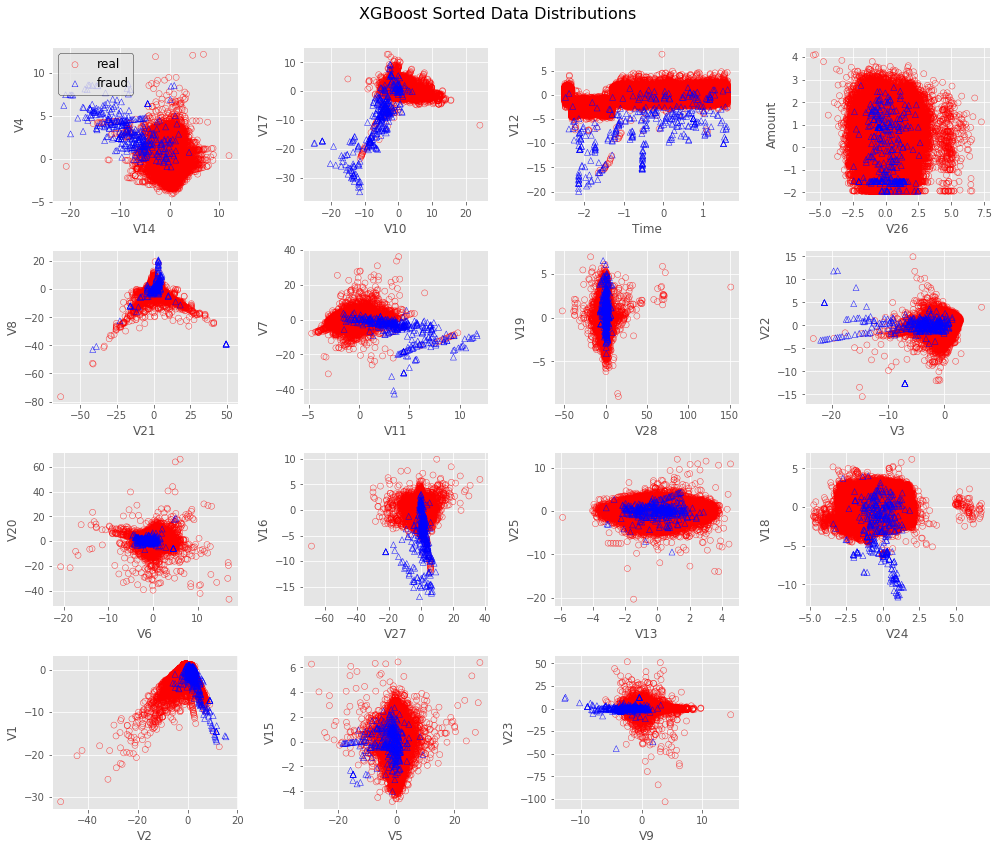

In [62]:
# Plot all of the training data with paired features sorted by importance
# This takes a while

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']
alphas = [0.7, 0.9]

columns = 4
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns*3.5, rows*3) )
plt.suptitle('XGBoost Sorted Data Distributions ', size=16)

train = train_df.copy()

for i in range( int(np.floor(len(sorted_x)/2)) )[:]:
    col1, col2 = sorted_x[i*2][0], sorted_x[i*2+1][0]
#     print(i,col1,col2)
    
    plt.subplot(rows,columns,i+1)  
    for group, color, marker, label, alpha in zip( train.groupby('Class'), colors, markers, labels, alphas ):
        plt.scatter( group[1][col1], group[1][col2], 
                         label=label, marker=marker, alpha=alpha,
                         edgecolors=color, facecolors='none' )         
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    plt.tick_params(axis='both', labelsize=10)
    if i == 0: plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/XGB_Sorted_Data_Distributions.png')
plt.show()

In [63]:
# load clustering libraries

import sklearn.cluster as cluster

In [64]:
# hdbscan not in kaggle/python at present

import hdbscan

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Running setup.py bdist_wheel for hdbscan: started
  Running setup.py bdist_wheel for hdbscan: finished with status 'error'
  Complete output from command C:\Users\Lillian\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\Lillian\\AppData\\Local\\Temp\\pip-install-nawg9c0s\\hdbscan\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d C:\Users\Lillian\AppData\Local\Temp\pip-wheel-ceslm0q1 --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.6
  creating build\lib.win-amd64-3.6\hdbscan
  copying hdbscan\hdbscan_.py -> build\lib.win-amd64-3.6\hdbscan
  copying hdbscan\plots.py -> build\lib.win-amd64-3.6\hdbscan
  copying hdbscan\prediction.py -> build\lib.win-amd64-3.6\hdbscan
  copying hd

  Failed building wheel for hdbscan
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
Command "C:\Users\Lillian\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\Lillian\\AppData\\Local\\Temp\\pip-install-nawg9c0s\\hdbscan\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\Lillian\AppData\Local\Temp\pip-record-_98m824s\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\Lillian\AppData\Local\Temp\pip-install-nawg9c0s\hdbscan\
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


ModuleNotFoundError: No module named 'hdbscan'

In [ ]:
# Set up training set to consist of only fraud data

train = data.loc[ data['Class']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['Class']==i)] for i in np.unique(train['Class']) ], columns=['count'], index=np.unique(train['Class']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]

In [ ]:
%%time

# TSNE is an interesting method to map higher dimensional data into two dimensions
# http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Note TSNE map may not be what you might think:
# https://distill.pub/2016/misread-tsne/

# Create multiple projections to compare results from different random states

from sklearn.manifold import TSNE

projections = [ TSNE(random_state=i).fit_transform(train_no_label) for i in range(3) ]

In [ ]:
%%time 

# Now we'll compare some different clustering algorithms
# https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/comparing_clustering_algorithms.rst

algorithms = [ 
#     [ 'KMeans', cluster.KMeans, (), {'random_state':0} ],
    [ 'KMeans', cluster.KMeans, (), {'n_clusters':2, 'random_state':0} ],
#     [ 'KMeans 3', cluster.KMeans, (), {'n_clusters':3, 'random_state':0} ],
#     [ 'Agglomerative', cluster.AgglomerativeClustering, (), {} ],
    [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],
#     [ 'Agg. Ave 3', cluster.AgglomerativeClustering, (), {'linkage': 'average', 'n_clusters': 3} ],
#     [ 'Agg. Complete 3', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 3} ],
#     [ 'DBSCAN', cluster.DBSCAN, (), {'eps':0.025} ],
#     [ 'HDBSCAN', hdbscan.HDBSCAN, (), {} ],
    [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1, } ],
#     [ 'HDBSCAN 2 10', hdbscan.HDBSCAN, (), {'min_cluster_size':2, 'min_samples':10, } ],
#     [ 'HDBSCAN 10 10 ', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':10, } ],
]

rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
    print(i, name)

    labels = algorithm(*args, **kwds).fit_predict(train_no_label)
#     labels = algorithm(*args, **kwds).fit_predict(projections[0])
    
#     print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )
    
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]
    
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

    for j in range(3):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors) 
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)
        
#     break

plt.suptitle('Comparison of Fraud Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('plots/Fraud_Cluster_Diagram.png')
plt.show()

In [ ]:
# Now pick a set of labels and add to the dataset

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)
# labels = algorithm(*args, **kwds).fit_predict(projections[0])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels

In [ ]:
# Let's see which features are most useful for detecting differences between the classes:

dtrain = xgb.DMatrix(fraud_w_classes[data_cols], fraud_w_classes['Class'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
    }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )